# Feature extraction - single recording

In [1]:
addpath('../Classes','../Functions')
set(0, 'defaultFigureRenderer', 'painters')
warning('off','all')

### Set parameters

In [2]:
sorting_path = fullfile(fileparts(cd),"/Data/Sorting_example"); %
params.QC.amp = nan; %Amplitude thresholds to exclude units, either [min_amp max_amp] or nan for no amplitude filtering
params.QC.rate = [0.1 10]; %Firing rate thresholds to exclude units, either [min_rate max_rate] or nan for no firing rate filtering
params.QC.rv = 0.02; %Maximum refractory period violations in [%], default is 0.02
params.Bursts.N = 0.0015; %Parameters for burst detection, for details see Bakkum et al., 2014 (https://doi.org/10.3389/fncom.2013.00193)
params.Bursts.ISI_N = 1.5;
params.Bursts.merge_t = 2;
params.Regularity.binning = 0.1; %Binning for regularity calculations
params.Bursts.binning = 0.1; %Binning for burst quantifications

Having specified all necessary parameters, we can now run the feature  extraction. We use an object-oriented approach, which means that the  feature extraction results in one object for each listed spikesorted recording. This will help us later to filter recordings by metadata or feature values.

### Run main feature extraction
This will take some time, depending on the number of templates and the length of the recording. 

#### !!! For some reason jupyter becomes unresponsive when the feature extraction code is executed through the Matlab Engine API. We therefore load a previously created file. !!!

In [4]:
%nw = WholeNetwork(sorting_path,params); %Normally this line would be run to extract features
load('../Data/Sorting_example/example_network.mat')

### Annotate metadata
If we analyze individual recordings, we want to associated some metadata with it. This can be easily done by setting:

In [5]:
nw.RecordingDate = 220209;

Several more properties are available to store metadata, such as PlatingDate, Mutation, Treatment etc. If we want to systematically compare different lines/treatment conditions, we will automate the annotation process (see feature_extraction_grouped).

### Visualization of the network
Now let's take a look at the data. This plot will give us a nice overview over the network and 

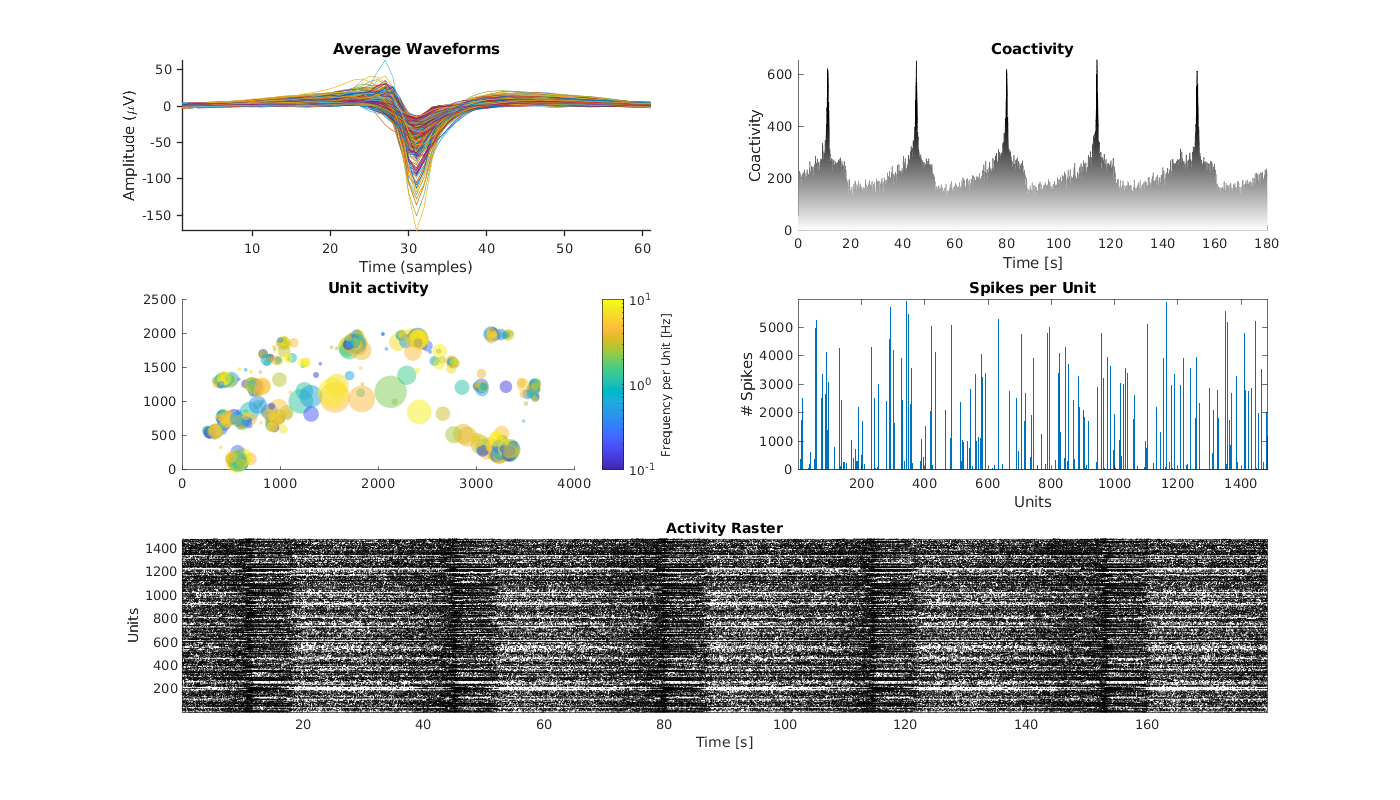

In [10]:
%plot --size 1400,800
nw.plotOverview;

We  can also look at each one of the subplots individually:

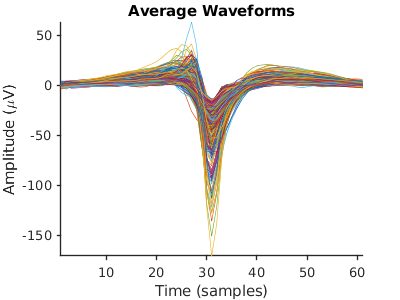

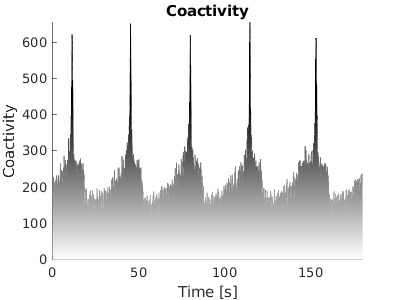

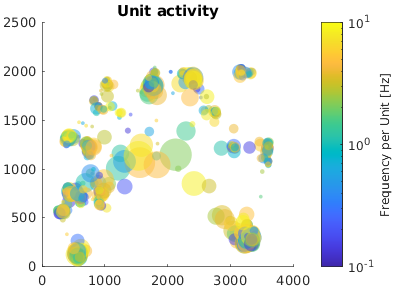

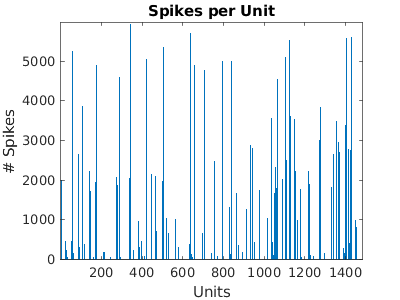

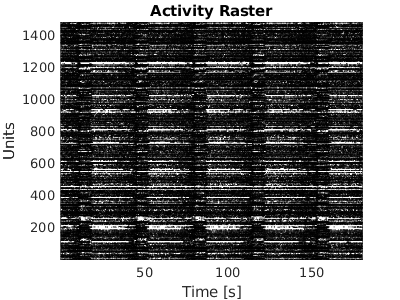

In [12]:
%plot --size 400,300
figure;
nw.plotWaveforms; title('Average Waveforms')

figure;
nw.plotCoactivity(0.1);  title('Coactivity')

figure;
nw.plotNetworkActivity; title('Unit activity')

figure;
nw.plotSpikePerUnit; title('Spikes per Unit')

figure;
nw.plotActivityRaster(0,180); title('Activity Raster')

### Check burst detection
Next, we should check if the burst detection functioned as expected and adjust the parameters if necessary. Depending on your dataset, you might have to set the parameters differently for each dataset. 

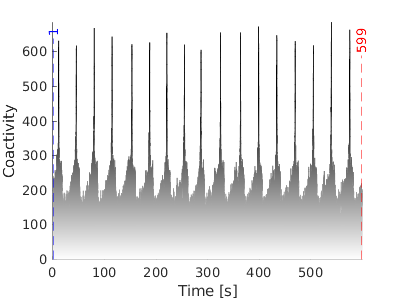

In [13]:
burst_ids = 1:10; %We check the first 10 bursts
figure;nw.plotCoactivity(params.Bursts.binning, burst_ids); 

The warning already tells us that there were no 10 bursts detected in the whole recording, and the plot shows us why. Apparently, we set the parameters incorrectly and the whole recording was considered to be one long burst. 

### Burst parameter adjustments
Let's tweak the parameters and see if we can improve the performance. Since we do not instantiate the whole object again, we have to change the parameters in the object directly using the nw.Params.Bursts properties:

Assigning Burst information.
Finished burst detection using 10.00 minutes of spike data.


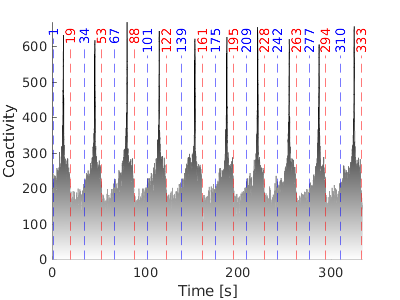

In [14]:
nw.Params.Bursts.ISI_N = 1; %Reduced from 1.5
nw.getBurstTimes;
figure;nw.plotCoactivity(params.Bursts.binning, burst_ids); 

That looks much better! This step might take several adjustments, so make sure that you do it properly.
After the burst detection adjustments, we also have to recalculate the statistics. We can do that by calling:

In [15]:
nw.getBurstStatistics;

### Accessing feature values
#### Network features
Feature values are associated with the WholeNetwork object, which you can extract using the [WholeNetworkObject].[FeatureName] notation, i.e. we can get the average burst duration of an object by:

In [16]:
nw.BDMean


ans =

   20.8061



or you can get the complete picture by simply calling the object itself:

In [17]:
nw


nw = 

  WholeNetwork with properties:

             lookup_path: '/cluster/project/bsse_sdsc/BELUB/Scripts/Cell_lines_lookup.mat'
               InputPath: "/home/philipp/Documents/Git/EphysDopa/Data/Sorting_example"
                  Params: [1x1 struct]
                Duration: 599.8601
               Templates: [1x1482 Template]
            XYElectrodes: [1006x2 double]
          ActiveChannels: [1x662 double]
                  Active: [3x1282696 double]
              SpikeTimes: [2x4732537 double]
            SamplingRate: 20000
          TemplateMatrix: [1484x61x1006 single]
       BaselineFrequency: 0.0357
    BaselineDistribution: 4.2695
                  Bursts: [1x1 struct]
                     IBI: [16x1 double]
                  IBIVar: 1.2594
                 IBIMean: 14.2936
                      BD: [17x1 double]
                  BDMean: 20.8061
                   BDVar: 4.0629
                 IntraBF: 3.7601
                 InterBF: 2.4686
                RiseTime:

#### Single cell features
WholeNetwork objects in return contain Template objects, that are associated with single cell features. To access individual feature values, we similarly can again retrieve it by calling [WholeNetworkObject].[TemplateObject].[FeatureName]:

In [20]:
template_id = 1; %Corresponds to the id of the spikesorting
nw.Templates(template_id).Asymmetry


ans =

   -0.0122



However, we are mostly interested in accessing the single cell features of all templates at the same time, which can be easily done by:

In [22]:
asymmetry_array = [nw.Templates.Asymmetry];

Some templates objects will be empty, which happens when they did not pass the quality check (see params.QC). To only access template objects that actually contain data, we can use the ActiveChannels property of the WholeNetwork object: 

In [23]:
template_id = nw.ActiveChannels(1);
nw.Templates(template_id).Asymmetry


ans =

   -0.0122



### Visualization of templates
Finally, we can also visually inspect templates, e.g. for manual curation:

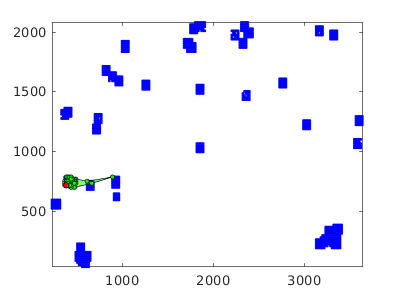

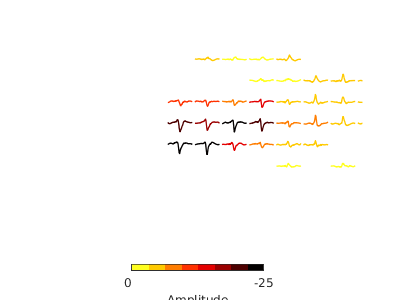

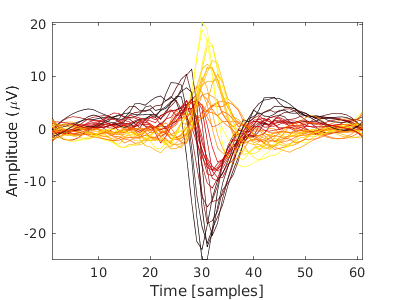

In [24]:
temp = nw.Templates(template_id);

figure;
temp.plotActiveElectrodes; %Plots all selected electrodes of the recording and highlights the ones belonging to the template


figure;
temp.calcSpread(1); %Plots the footprint of the template

figure;
temp.plotWf; %Plots the waveforms of all active electrodes 

### Saving the results
If we saved the results in their current state, they would use up quite a bit of storage space. Therefore, we have two functions to only store relevant information, i.e. calculated feature values:

In [ ]:
save_path = pwd; %Change 
nw.saveNW(save_path); %Saves only network features, deletes templates

or

In [ ]:
nw.saveTMP(save_path); %Saves network and single cell features, deletes only large arrays (e.g., template matrix)